In [1]:
import pandas as pd
import sys
sys.path.append("../../LigandNet/scripts")
# sys.path.append("../utilities/utility.py")
from utility import FeatureGenerator

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [35]:
def get_ecfp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, 3).ToBitString()
    return [int(s) for s in ecfp]

In [147]:
class FeatureTypeNotSupported(Exception):
    """ Raised when the provided feature type is not supported"""
    pass

class Dataset:
    # Supported feature types
    _feature_types = ["ecfp-6"]
    X = None
    y = None
    _df = pd.DataFrame()
    _smiles_field = None
    _target_field = None
    smiles = None
    targets = None
    
    def __init__(self, df, smiles_field, target_field):
        # clean the dataset
        self._df = df if len(df)>0 else None
        self._smiles_field = smiles_field
        self._target_field = target_field
        
        # Clean the data
        self._clean_data()
        
        # Populate the smiles and target list
        self._get_smiles_targets()
    
    def _get_smiles_targets(self):
        self.smiles = self._df[self._smiles_field].values.tolist()
        self.targets = self._df[self._target_field].values.tolist()
        
    def _clean_data(self):
        if self._df is None: return
        # Drop Nan values
        # self._df = df.dropna(axis=0)
        # Check the target field
        self._df = self._df[np.isfinite(self._df[self._target_field])]
        
    def _get_ecfp6(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, 3).ToBitString()
        return [int(s) for s in ecfp]
    
    def create_dataset(self, feature_type="ecfp-6"):
        if feature_type not in self._feature_types:
            raise FeatureTypeNotSupported("Feature type is not supported.")
        self.X = np.array([self._get_ecfp6(s) for s in self.smiles], dtype=np.float32)
        self.y = np.array(self.targets, dtype=np.float32)

In [151]:
data_df = pd.read_csv("data/curated_data.csv")
data_df.head()

,CMPD_CHEMBLID,COMPOUND_KEY,MOLWEIGHT,ALOGP,PSA,CANONICAL_SMILES,Km,Vmax,pKm
0,CHEMBL300797,L-tyrosine methyl ester,195.22,0.43,72.55,COC(=O)[C@@H](N)Cc1ccc(O)cc1,4000000.0,350.0,-15.201805
1,CHEMBL1288,1-Naphthalenemethanol,158.20,2.33,20.23,OCc1cccc2ccccc12,30000.0,26.0,-10.308953
2,CHEMBL14060,Phenol,94.11,1.39,20.23,Oc1ccccc1,19000.0,350.0,-9.852194
3,CHEMBL14126,2-naphthol,144.17,2.55,20.23,Oc1ccc2ccccc2c1,8000.0,1130.0,-8.987197
4,CHEMBL3085280,4-ethylbenzyl alcohol,488.55,0.27,163.53,N[C@@H](C(=O)NC1C2SCC(=C(N2C1=O)C(=O)O)CSc3c[n...,60000.0,182.0,-11.002100


In [152]:
# # Extract features
# def get_features(SMILES):
#     try:
#         feat_gen = FeatureGenerator(SMILES)
#         return feat_gen.toTPATF()
#     except Exception as e:
#         print(str(e))
#         return float('NaN')

### Model for Km

In [157]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline

In [216]:
random_state = 1

In [210]:
dataset = Dataset(data_df, smiles_field="CANONICAL_SMILES", target_field="pKm")
dataset.create_dataset()
train_x, test_x, train_y, test_y = train_test_split(dataset.X, dataset.y, test_size=0.3, random_state = random_state)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(37, 2048) (37,) (16, 2048) (16,)


In [222]:
params = {"n_estimators": [i for i in range(10, 501, 10)], 
          "oob_score": [True, False], 
          "n_jobs": [-1], 
          "random_state": [random_state]}
rf_clf = RandomForestRegressor()
grid_clf = GridSearchCV(rf_clf, param_grid=params)
grid_clf.fit(train_x, train_y)

/home/mhassan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/mhassan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/mhassan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500], 'oob_score': [True, False], 'n_jobs': [-1], 'random_state': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [223]:
clf = grid_clf.best_estimator_
clf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=-1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [224]:
clf = grid_clf.best_estimator_
clf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=-1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [225]:
train_pred = clf.predict(train_x)
train_r2 = r2_score(y_pred=train_pred, y_true=train_y)
test_pred = clf.predict(test_x)
test_r2 = r2_score(y_pred=test_pred, y_true=test_y)
print(train_r2, test_r2)

0.9297958530633246 0.6872444314947843


In [206]:
train_pred = clf.predict(train_x)
train_r2 = r2_score(y_pred=train_pred, y_true=train_y)
test_pred = clf.predict(test_x)
test_r2 = r2_score(y_pred=test_pred, y_true=test_y)
print(train_r2, test_r2)

[Parallel(n_jobs=56)]: Done  70 out of  90 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=56)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=56)]: Done  70 out of  90 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=56)]: Done  90 out of  90 | elapsed:    0.0s finished


0.9069055285578072 0.7670636337630219


In [215]:
train_pred = clf.predict(train_x)
train_r2 = r2_score(y_pred=train_pred, y_true=train_y)
test_pred = clf.predict(test_x)
test_r2 = r2_score(y_pred=test_pred, y_true=test_y)
print(train_r2, test_r2)

[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.0s
[Parallel(n_jobs=56)]: Done 400 out of 400 | elapsed:    0.1s finished


0.9267644771551218 0.6854295959526698


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.0s
[Parallel(n_jobs=56)]: Done 400 out of 400 | elapsed:    0.1s finished


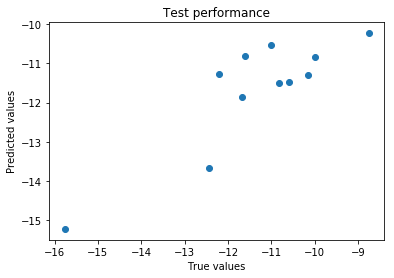

In [189]:
plt.figure()
plt.scatter(test_y, test_pred)
plt.title("Test performance")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

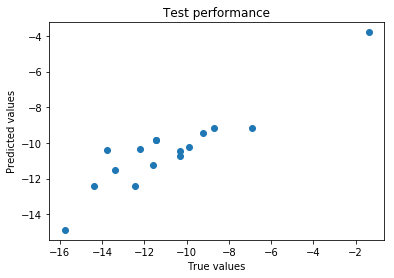

In [207]:
plt.figure()
plt.scatter(test_y, test_pred)
plt.title("Test performance")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

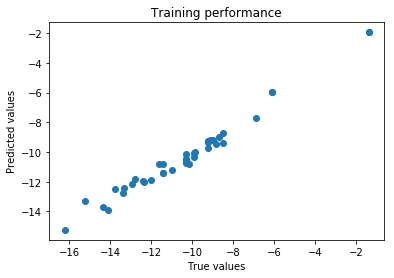

In [190]:
plt.figure()
plt.scatter(train_y, train_pred)
plt.title("Training performance")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

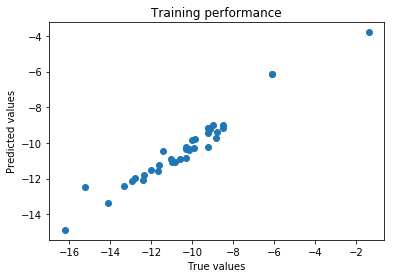

In [208]:
plt.figure()
plt.scatter(train_y, train_pred)
plt.title("Training performance")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

In [193]:
joblib.dump(clf, "Km_model.clf")

['Km_model.clf']

### Vmax Model

In [194]:
dataset = Dataset(data_df, smiles_field="CANONICAL_SMILES", target_field="Vmax")
dataset.create_dataset()
train_x, test_x, train_y, test_y = train_test_split(dataset.X, dataset.y, test_size=0.2)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(42, 2048) (42,) (11, 2048) (11,)


In [202]:
params = {"n_estimators": [i for i in range(10, 501, 10)], "oob_score": [True, False], "n_jobs": [-1], "random_state": [1]}
rf_clf = RandomForestRegressor(verbose=True)
grid_clf = GridSearchCV(rf_clf, param_grid=params)
grid_clf.fit(train_x, train_y)

In [197]:
clf = grid_clf.best_estimator_
clf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=True, random_state=1,
           verbose=True, warm_start=False)

In [198]:
train_pred = clf.predict(train_x)
train_r2 = r2_score(y_pred=train_pred, y_true=train_y)
test_pred = clf.predict(test_x)
test_r2 = r2_score(y_pred=test_pred, y_true=test_y)
print(train_r2, test_r2)

[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


0.7636706913309964 0.36297914592850367


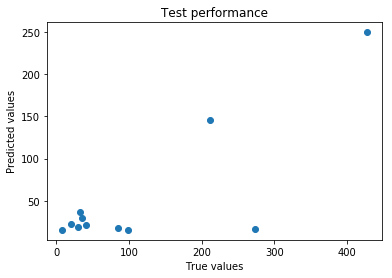

In [199]:
plt.figure()
plt.scatter(test_y, test_pred)
plt.title("Test performance")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

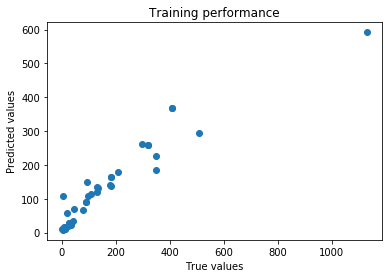

In [200]:
plt.figure()
plt.scatter(train_y, train_pred)
plt.title("Training performance")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

In [201]:
joblib.dump(clf, "vmax_model.clf")

['vmax_model.clf']